In [9]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ML model and preprocessing imports
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

# Pipeline imports
from sklearn.pipeline import Pipeline, make_pipeline

# External libraries
import xgboost as xgb

# Local imports
from ML_preprocessing import prepare_data_for_ML

# Getting data

In [10]:
X_train, X_test, y_train, y_test = prepare_data_for_ML("BTC/USDT", day_to_forecast=1)

# Distributins after transformation 


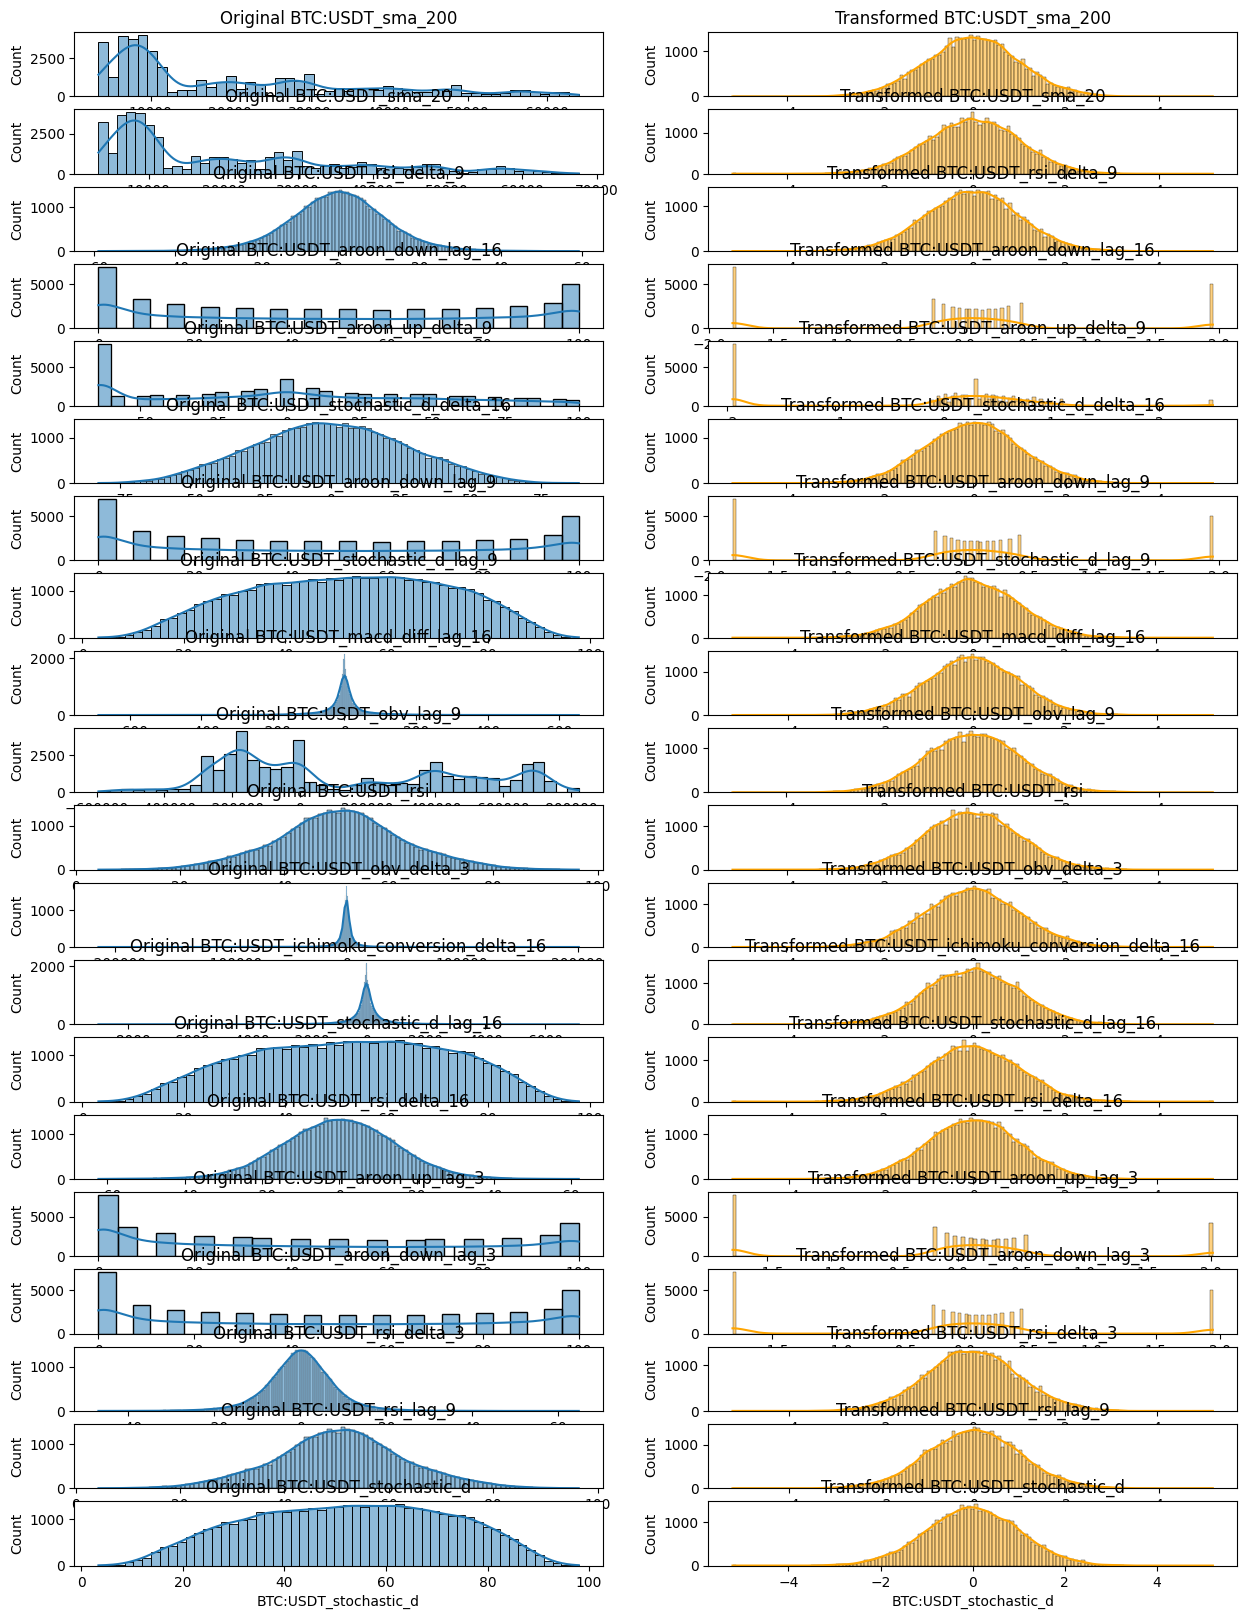

In [7]:
# Apply Quantile Transformer
transform_pipe = Pipeline(
    [
        (
            "Normilizer",
            QuantileTransformer(output_distribution="normal", random_state=99),
        ),
        ("Scaler", StandardScaler()),
    ]
)
X_train_transformed = transform_pipe.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns)

# Select 20 random columns (same as before)
num_cols = min(len(X_train.columns), 20)
random_columns = np.random.choice(X_train.columns, num_cols, replace=False)

# Set up the matplotlib figure (2 rows for each column: before and after)
plt.figure(figsize=(15, 2 * 20))  # Adjust the size as needed

# Plot each histogram before and after transformation
for i, col in enumerate(random_columns):
    # Original Data
    plt.subplot(2 * num_cols, 2, 2 * i + 1)  # 2*num_cols rows, 2 columns per row
    sns.histplot(X_train[col], kde=True)
    plt.title(f"Original {col}")
    # plt.tight_layout()

    # Transformed Data
    plt.subplot(2 * num_cols, 2, 2 * i + 2)
    sns.histplot(X_train_transformed[col], kde=True, color="orange")
    plt.title(f"Transformed {col}")
    # plt.tight_layout()

plt.show()

# Test of feature selection

In [ ]:
# Example using RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
sfm = SelectFromModel(model)

# Assume X_train and y_train are your training data and labels
sfm.fit(X_train, y_train)

# To see the features selected
selected_features = sfm.get_support()
print("Selected features:", selected_features)

# To get the names of the selected features if you have a DataFrame
selected_feature_names = X_train.columns[selected_features]
print("Selected feature names:", selected_feature_names)

Selected features: [ True  True  True  True  True  True  True  True  True  True  True False
 False False False False False  True False False False False False False
 False False False False False False False False  True  True  True False
 False False False False False False  True False False False False False
  True  True  True False False False False False False  True  True False
 False False False]
Selected feature names: Index(['BTC:USDT_sma_9', 'BTC:USDT_sma_20', 'BTC:USDT_sma_50',
       'BTC:USDT_sma_200', 'BTC:USDT_rsi', 'BTC:USDT_bollinger_up',
       'BTC:USDT_bollinger_down', 'BTC:USDT_adx', 'BTC:USDT_macd_diff',
       'BTC:USDT_obv', 'BTC:USDT_ichimoku_conversion', 'BTC:USDT_obv_lag_3',
       'BTC:USDT_macd_diff_lag_9', 'BTC:USDT_obv_lag_9',
       'BTC:USDT_ichimoku_conversion_lag_9',
       'BTC:USDT_ichimoku_conversion_delta_9', 'BTC:USDT_macd_diff_lag_16',
       'BTC:USDT_obv_lag_16', 'BTC:USDT_ichimoku_conversion_lag_16',
       'BTC:USDT_obv_delta_16', 'BTC:USDT_ich

# Pipeline

In [14]:
# Preprocessing pipeline
preprocessing = make_pipeline(
    QuantileTransformer(output_distribution="normal", random_state=99),
    StandardScaler(),
    SelectFromModel(RandomForestRegressor(random_state=99)),
)

# Define the pipelines for each model
pipelines = {
    "Random_Forest": Pipeline(
        [
            ("prep", preprocessing),
            ("model", RandomForestRegressor(random_state=99)),
        ]  # Winner
    ),
    "Gradient_Boosting": Pipeline(
        [("prep", preprocessing), ("model", GradientBoostingRegressor(random_state=99))]
    ),
    "Linear_Regression": Pipeline(
        [("prep", preprocessing), ("model", LinearRegression())]
    ),
    "K-Nearest_Neighbors": Pipeline(
        [("prep", preprocessing), ("model", KNeighborsRegressor())]
    ),
    "XGBoost": Pipeline(
        [
            ("prep", preprocessing),
            ("model", xgb.XGBRegressor(random_state=99)),
        ]  # Second place
    ),
    "SVR": Pipeline([("prep", preprocessing), ("model", SVR())]),
    "ElasticNet": Pipeline([("prep", preprocessing), ("model", ElasticNet())]),
}

# Testing of default models

In [15]:
scores = {}
for name, pipeline in pipelines.items():
    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
    )
    scores[name] = -score  # Negate to get positive MSE values back

scores_df = pd.DataFrame(scores)

scores_df.to_csv("models_results.csv")

scores_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Random_Forest,Gradient_Boosting,Linear_Regression,K-Nearest_Neighbors,XGBoost,SVR,ElasticNet
0,0.000431,0.001549,0.001683,0.000983,0.000699,0.002110,0.001704
1,0.000310,0.001447,0.001596,0.000850,0.000633,0.001943,0.001620
2,0.000393,0.001490,0.001626,0.000925,0.000736,0.002061,0.001651
3,0.000341,0.001452,0.001590,0.000821,0.000660,0.001946,0.001601
4,0.000337,0.001365,0.001512,0.000850,0.000630,0.001865,0.001531


In [16]:
scores_df.mean()

Random_Forest          0.000362
Gradient_Boosting      0.001461
Linear_Regression      0.001601
K-Nearest_Neighbors    0.000886
XGBoost                0.000671
SVR                    0.001985
ElasticNet             0.001621
dtype: float64

# Fine-tuning


In [17]:
preprocessing = make_pipeline(
    QuantileTransformer(output_distribution="normal", random_state=99),
    StandardScaler(),
    SelectFromModel(RandomForestRegressor(random_state=99)),
)

random_forest = Pipeline(
    [
        ("prep", preprocessing),
        ("model", RandomForestRegressor(random_state=99)),
    ]  # Winner
)

xgboost = Pipeline(
    [
        ("prep", preprocessing),
        ("model", xgb.XGBRegressor(random_state=99)),
    ]  # Second place
)

In [ ]:
"""
TO DO 

1. Tests on X_test (with all metrics -
mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score

2. Grid or Random with best model

"""

In [ ]:
param_grid = {
    "model__n_estimators": [100, 200, 300, 400],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["auto", "sqrt", "log2"],
}

# Create a RandomizedSearchCV object
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings that are sampled. Adjust as needed.
    cv=5,
    verbose=2,
    n_jobs=-1,  # Using all processors
    random_state=99,  # Optional, for reproducible results
)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use best_params and best_model as needed